In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random
import seaborn as sns

In [2]:
def removeDS(array):
    if '.DS_Store' in array:
        array.remove('.DS_Store')
    
    return array

In [3]:
def get_Nclasses_cutoff(path, N):
    '''
    This function is used to get the number of clips contained in the top N classes when sorted by number of clips.
    '''
    labels = os.listdir(path)
    labels = removeDS(labels)
        
    clip_nums = []
    for label in labels:
        label_path = path + label + '/'
        clips = os.listdir(label_path)
        clips = removeDS(clips)
        clip_nums.append(len(clips))
            

    clip_nums.sort(reverse=True)
    cutoff = clip_nums[N-1]
    
    return cutoff

In [4]:
def read_labels(path, cutoff):
    '''
    This function is used to get the number of clips contained in the top N classes when sorted by number of clips.
    '''
    labels = os.listdir(path)
    labels = removeDS(labels)
    
    bounding_boxes = []
        
    for label in labels:
        label_path = path + label + '/'
        clips = os.listdir(label_path)
        clips = removeDS(clips)

        if len(clips) > cutoff:
            for clip in clips:
                clip_path = label_path + clip
                files = os.listdir(clip_path)
                files = removeDS(files)
                for file in files:
                    file_path = clip_path + '/' + file
                    data = np.loadtxt(file_path)
                    #assuming (x1, y1), (x2, y2)
                    width = (data[3] - data[1])/224
                    height = (data[4] - data[2])/224
                    bounding_boxes.append([width, height])
    
    return bounding_boxes
            
    

In [5]:
list_root = 'ucf24/splitfiles/' 
path = 'ucf24/labels/'  

cutoff = get_Nclasses_cutoff(path, 5)
bounding_boxes = read_labels(path, cutoff)

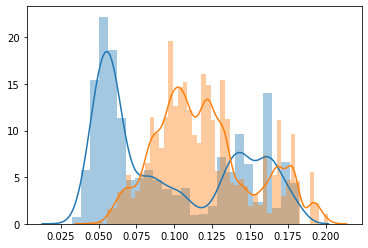

In [6]:
sns.distplot(np.array(bounding_boxes)[:,0])
sns.distplot(np.array(bounding_boxes)[:,1])

In [117]:
def jaccard_index(box1, box2):
    num = min(box1[0], box2[0]) * min(box1[1], box2[1])
    den = box1[0]*box1[1] + box2[0]* box2[1] - num
    
    distance = num/den
    
    return distance

In [7]:
def euclidean_dist(box1, box2):
    distance = (box1[0] - box2[0])**2 + (box1[1] - box2[1])**2
    dist = distance ** 0.5 
    
    return dist

In [8]:
def initialize(K):
    cluster_mean = []
    for i in range(K):
        cluster_mean.append([random.random()*0.2, random.random()*0.2])
        
    return cluster_mean
    
    

In [9]:
def find_clusters(bounding_boxes, cluster_mean):

    cluster = np.zeros(len(bounding_boxes), dtype = int)
    
    for i in range(len(bounding_boxes)):
        
        min_dist = 1000
        for k in range(K):
            distance = jaccard_index(bounding_boxes[i], cluster_mean[k])
            #distance = euclidean_dist(bounding_boxes[i], cluster_mean[k])
            if distance < min_dist:
                min_dist = distance
                cluster[i] = k

    return cluster
            
            
        

In [10]:
def new_cluster(bounding_boxes, cluster, old_cluster_mean, K):

    cluster_mean = []
    
    w_sum = np.zeros(K)
    h_sum = np.zeros(K)
    count = np.zeros(K)
    
    for i in range(len(bounding_boxes)):
        w_sum[cluster[i]] += bounding_boxes[i][0]
        h_sum[cluster[i]] += bounding_boxes[i][1]
        count[cluster[i]] += 1
        
    for k in range(K):
        if count[k] != 0:
            cluster_mean.append([w_sum[k]/count[k], h_sum[k]/count[k]])
        else:
            cluster_mean.append([old_cluster_mean[k][0], old_cluster_mean[k][1]])
        
    
    return cluster_mean

In [155]:
K = 9
T = 20
clustering_means = []
clustering_histories = []


In [156]:
cluster_mean = initialize(K)
#clustering_means.append(cluster_mean)

for t in range(T):
    #print('t = ', t)
    cluster = find_clusters(bounding_boxes, cluster_mean)
    clustering_histories.append(cluster)
    cluster_mean = new_cluster(bounding_boxes, cluster, cluster_mean, K)
    clustering_means.append(cluster_mean)

In [157]:
for t in range(T):
    num = []
    for k in range(K):
        num.append(sum(clustering_histories[t] == k))
        
    print(num)

[14911, 0, 1428, 6361, 0]
[10613, 1361, 910, 9816, 0]
[9001, 68, 468, 13163, 0]
[12511, 746, 980, 8463, 0]
[8487, 529, 639, 13045, 0]
[13005, 638, 589, 8468, 0]
[8467, 569, 639, 13025, 0]
[13025, 639, 569, 8467, 0]
[8467, 569, 639, 13025, 0]
[13025, 639, 569, 8467, 0]
[8467, 569, 639, 13025, 0]
[13025, 639, 569, 8467, 0]
[8467, 569, 639, 13025, 0]
[13025, 639, 569, 8467, 0]
[8467, 569, 639, 13025, 0]
[13025, 639, 569, 8467, 0]
[8467, 569, 639, 13025, 0]
[13025, 639, 569, 8467, 0]
[8467, 569, 639, 13025, 0]
[13025, 639, 569, 8467, 0]


In [13]:
def plot_clustering(clustering, K):
    
    time = len(clustering)
    
    cluster_history = []
    for k in range(K):
        w = []
        h = []
        for i in range(time):
            w.append(clustering[i][k][0])
            h.append(clustering[i][k][1])
            
        cluster_history.append([w,h])
        
    return cluster_history
            

def plot_history(cluster_history, K):
    for k in range(K):
        plt.figure(k)
        plt.plot(cluster_history[k][0] )
        plt.plot( cluster_history[k][1])
        plt.legend(['width', 'height'])
    
    
mean_history = plot_clustering(clustering_means, K)
#plot_history(mean_history, K)

In [158]:
def color(k):
    if k == 0:
        return 'b'
    if k == 1:
        return 'r'
    if k == 2:
        return 'g'
    if k == 3:
        return 'm'
    if k == 4:
        return 'y'
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


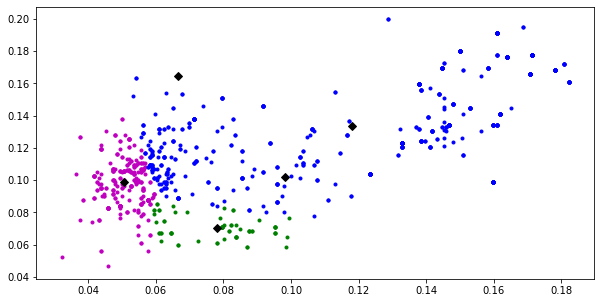

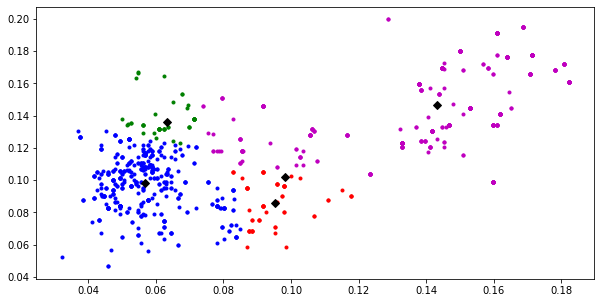

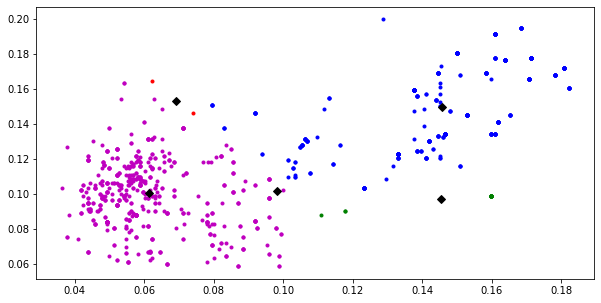

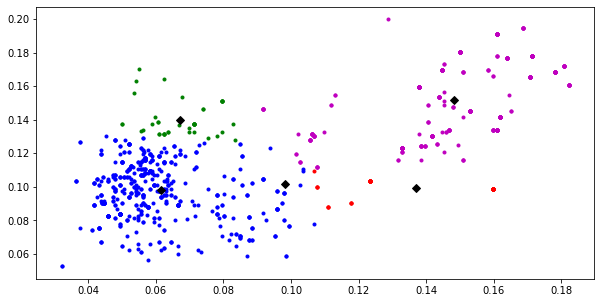

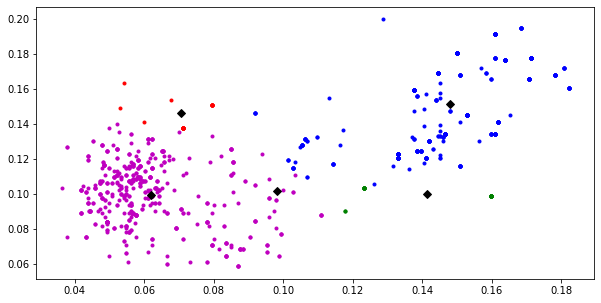

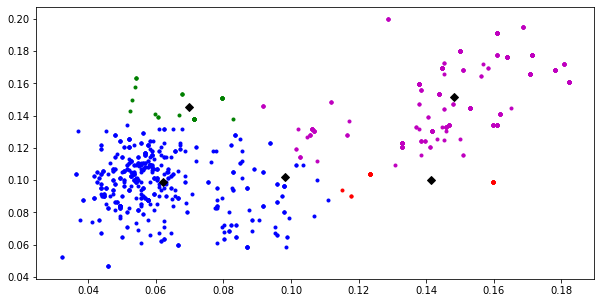

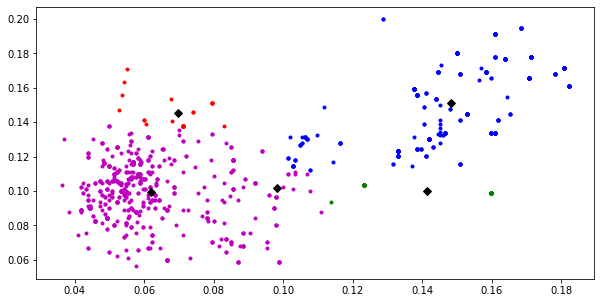

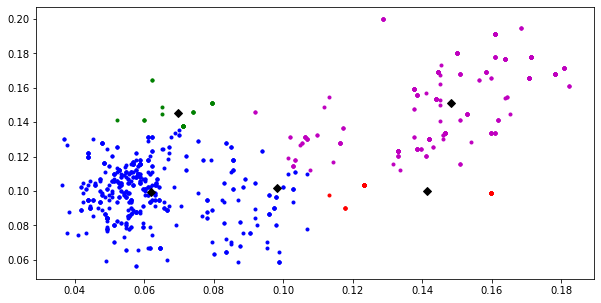

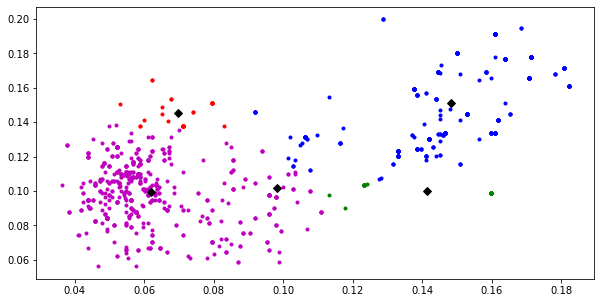

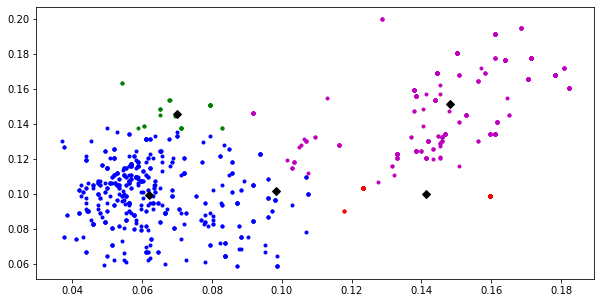

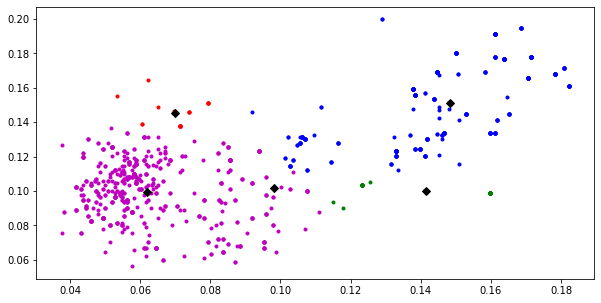

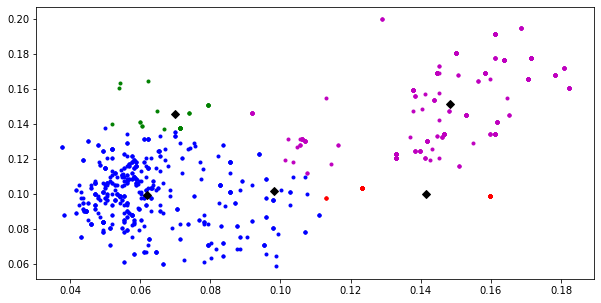

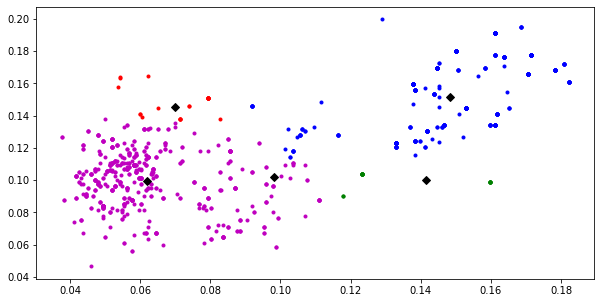

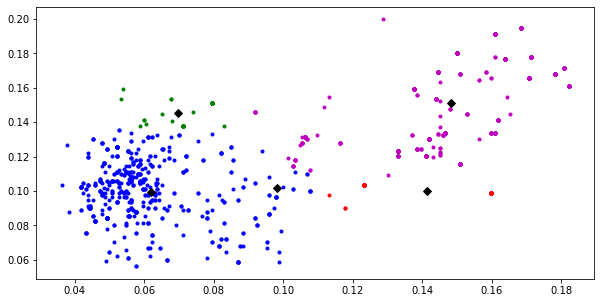

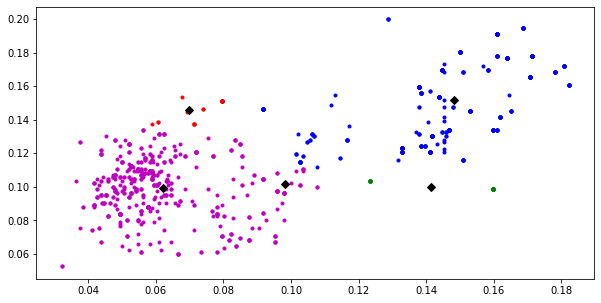

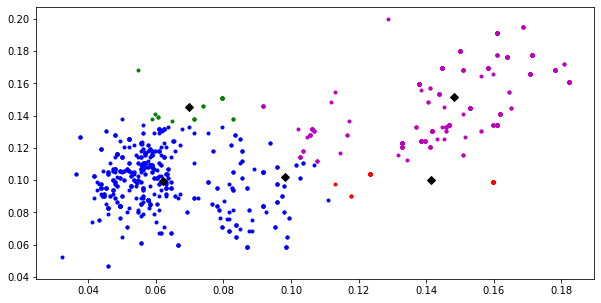

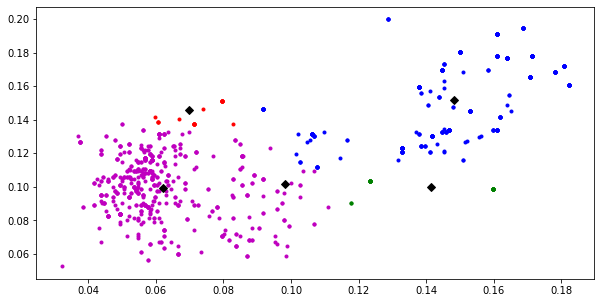

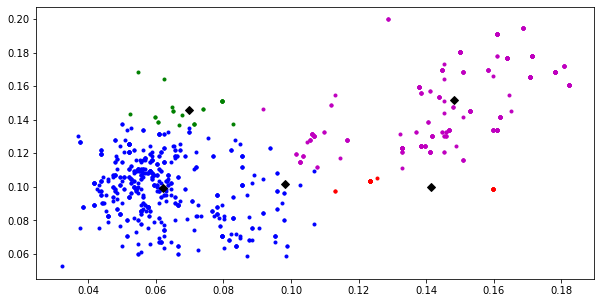

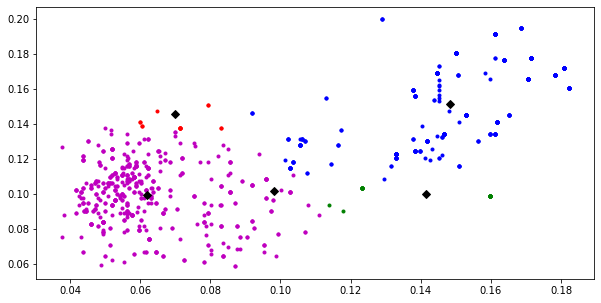

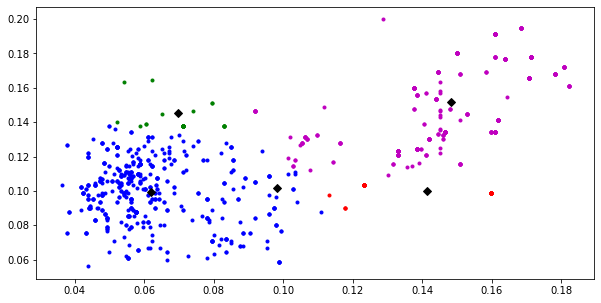

In [160]:
def plot_clusters_random(clustering_means, clustering_histories, bounding_boxes, K):
    
    time = len(clustering_means)
    boxes = len(clustering_histories[0])
    
    for t in range(time):
        print(t)
        plt.figure(t, figsize=(10,5))
        
        for c in range(1000):
            i = random.randint(0, boxes-1)
            plt.plot(bounding_boxes[i][0], bounding_boxes[i][1], color(clustering_histories[t][i]) + '.')
        
        for k in range(K):
            plt.plot(clustering_means[t][k][0], clustering_means[t][k][1], 'kD')
        
    
plot_clusters_random(clustering_means, clustering_histories, bounding_boxes, K)
            

IndexError: list index out of range

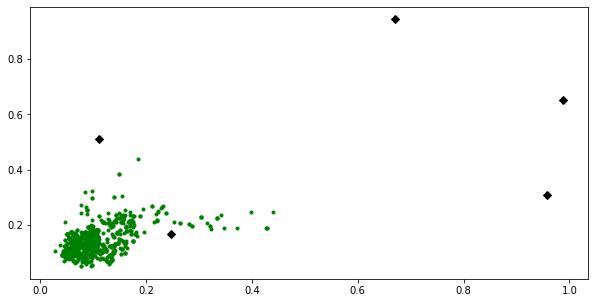

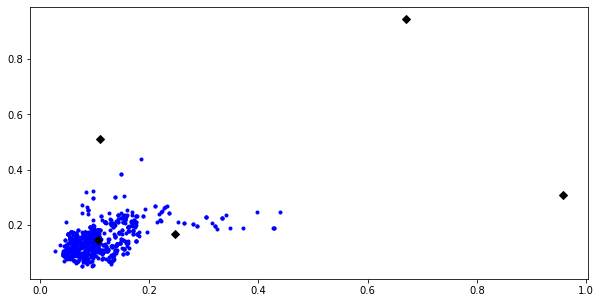

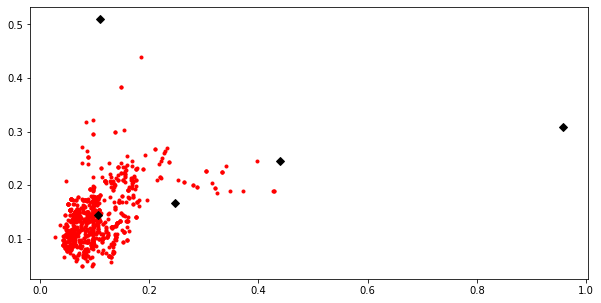

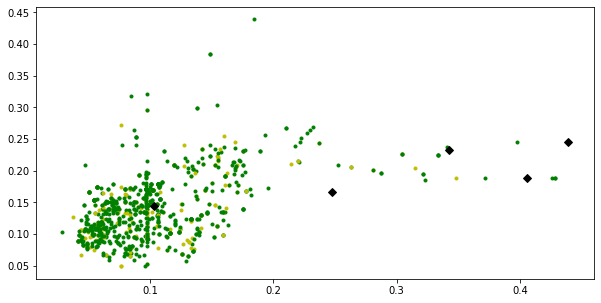

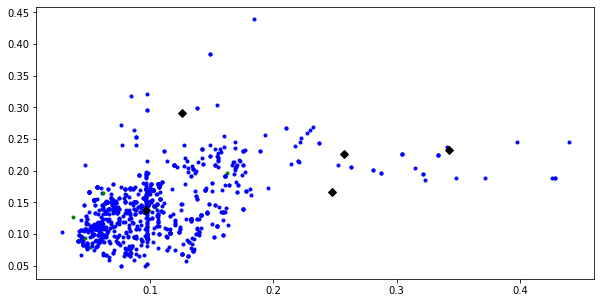

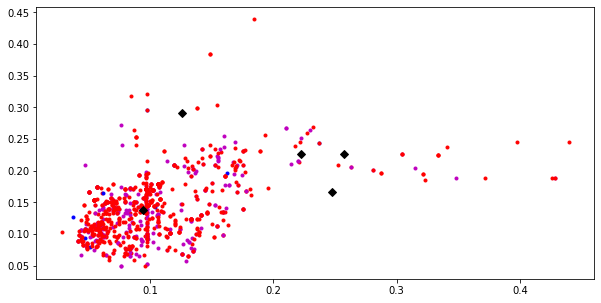

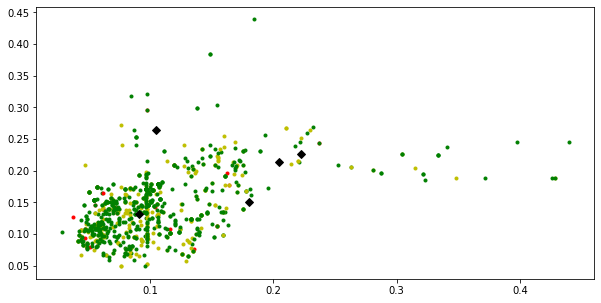

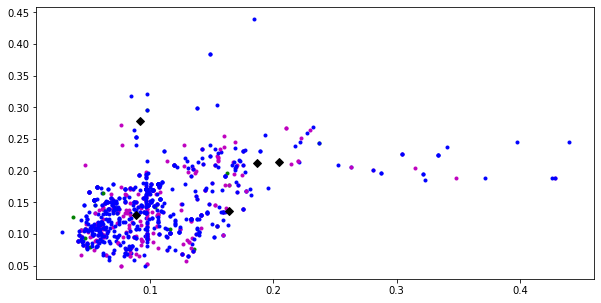

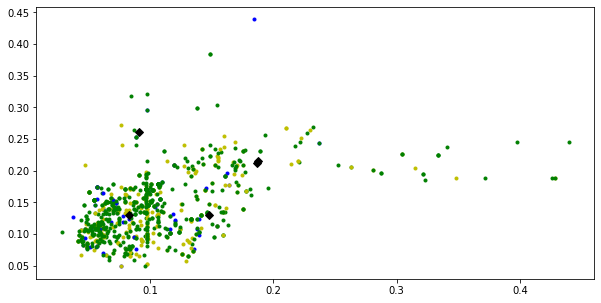

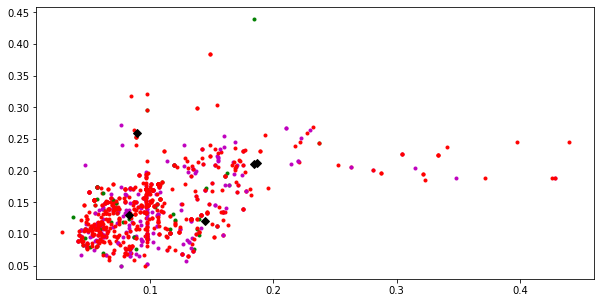

<Figure size 720x360 with 0 Axes>

In [27]:
def plot_clusters(clustering_means, clustering_histories, bounding_boxes, K):
    
    time = len(clustering_means)
    boxes = len(clustering_histories[0])
    
    for t in range(time):
        plt.figure(t, figsize=(10,5))
        for i in range(boxes):
            plt.plot(bounding_boxes[i][0], bounding_boxes[i][1], color(clustering_histories[t][i]) + '.')
            if i == 1000:
                break
        
        for k in range(K):
            plt.plot(clustering_means[t][k][0], clustering_means[t][k][1], 'kD')
        
    
plot_clusters(clustering_means, clustering_histories, bounding_boxes, K)
            

In [11]:
kmeans5 = KMeans(n_clusters=9)
y_kmeans5 = kmeans5.fit_predict(bounding_boxes)
print(y_kmeans5)

kmeans5.cluster_centers_

[7 7 7 ... 1 1 1]


array([[0.15007895, 0.14383067],
       [0.05270206, 0.09007093],
       [0.06635344, 0.13954863],
       [0.10121938, 0.12685433],
       [0.16361079, 0.17595709],
       [0.05599496, 0.11266954],
       [0.07685411, 0.06975086],
       [0.09296445, 0.0955179 ],
       [0.13889184, 0.11826541]])

In [129]:
for k in range(6):
    print('k = ', k, ': ', sum(y_kmeans5 == k))
    

k =  0 :  5067
k =  1 :  5146
k =  2 :  2665
k =  3 :  3587
k =  4 :  6235
k =  5 :  0


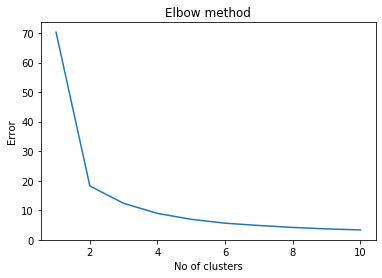

In [130]:
Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(bounding_boxes)
    kmeans.fit(bounding_boxes)
    Error.append(kmeans.inertia_)
import matplotlib.pyplot as plt
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

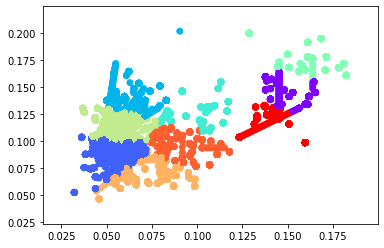

In [12]:
plt.scatter(np.array(bounding_boxes)[:,0], np.array(bounding_boxes)[:,1], c = y_kmeans5, cmap = 'rainbow')

In [64]:
np.array(bounding_boxes).shape

(95264, 2)